## 1. Introduction

Dataset: The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset, provided by Kaggle.

Data Size: The dataset consists of 220,025 training images and 57,458 test images.

Image Dimensions: Each image is 96x96 pixels.

Data Structure: Images are provided in a .tif format and are accompanied by a CSV file containing the image IDs and the corresponding labels (0 for non-cancerous, 1 for cancerous).


## 2. Exploratory Data Analysis (EDA)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

In [27]:
#df_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
#df_samples = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
df_labels = pd.read_csv('/Users/yeoshaojie/Desktop/Intro to Deep Learning/Week 3/histopathologic-cancer-detection/train_labels.csv')
df_samples = pd.read_csv('/Users/yeoshaojie/Desktop/Intro to Deep Learning/Week 3/histopathologic-cancer-detection/sample_submission.csv')
df_labels = df_labels.head(10000)
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [28]:
#train = '/kaggle/input/histopathologic-cancer-detection/train'
#test = '/kaggle/input/histopathologic-cancer-detection/test'

train = '/Users/yeoshaojie/Desktop/Intro to Deep Learning/Week 3/histopathologic-cancer-detection/train'
test = '/Users/yeoshaojie/Desktop/Intro to Deep Learning/Week 3/histopathologic-cancer-detection/test'

print("Number of images for training: {}".format(len(os.listdir(train))))
print("Number of images for testing: {}".format(len(os.listdir(test))))


Number of images for training: 220025
Number of images for testing: 57458


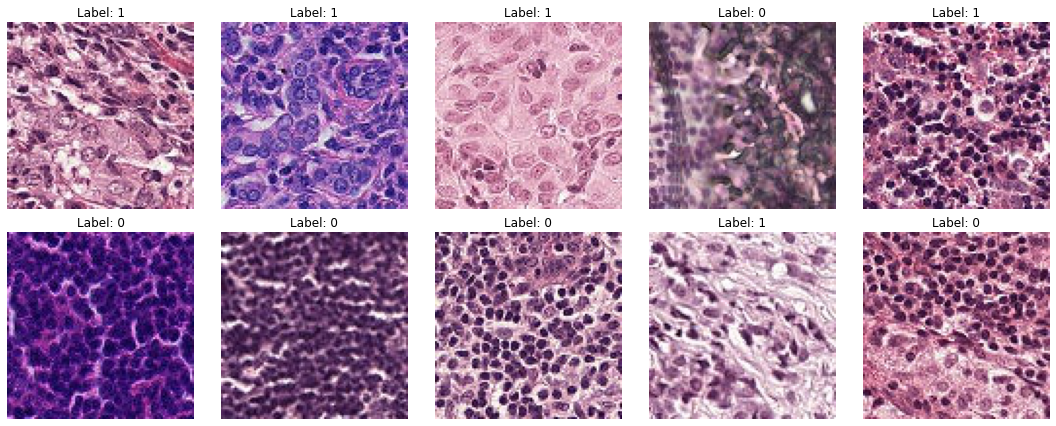

In [20]:
#show first 10 images
# Function to load and display images
def display_images(images, labels, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()
    
    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Label: {lbl}')
    
    plt.tight_layout()
    plt.show()

# Select 10 random images from the dataset
sample_data = df_labels.sample(n=10).reset_index(drop=True)
sample_images = []
sample_labels = []

# Load the images and their labels
for idx, row in sample_data.iterrows():
    img_path = os.path.join(train, f"{row['id']}.tif")
    img = Image.open(img_path)
    sample_images.append(img)
    sample_labels.append(row['label'])

# Display the images
display_images(sample_images, sample_labels)


In [7]:
# Check for missing values in the DataFrame
missing_values = df_labels.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Check for missing image files
missing_images = []
for idx, row in df_labels.iterrows():
    img_path = os.path.join(train, f"{row['id']}.tif")
    if not os.path.exists(img_path):
        missing_images.append(row['id'])

if missing_images:
    print(f"Missing image files for the following IDs: {missing_images}")
else:
    print("No missing image files.")


Missing values in each column:
id       0
label    0
dtype: int64
No missing image files.


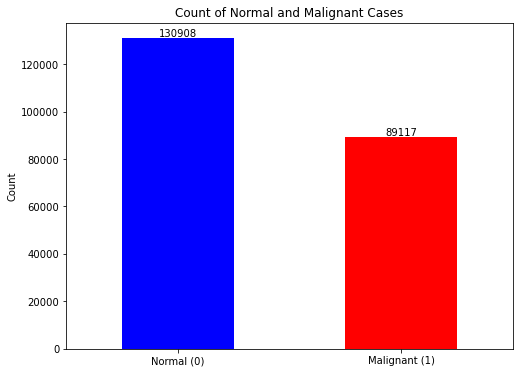

In [8]:
# Count the occurrences of each label (0 and 1)
label_counts = df_labels['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])

# Add counts on top of the bars
for index, value in enumerate(label_counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Count of Normal and Malignant Cases')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal (0)', 'Malignant (1)'], rotation=0)
plt.show()


In [9]:
def visualize_images(df_labels, title, train_images_dir, label, num_images=10):
    
    # Filter to get only images with the specified label
    selected_images = df_labels[df_labels['label'] == label]['id'].values

    # Randomly select the specified number of images
    selected_images = np.random.choice(selected_images, num_images, replace=False)

    # Plot the images
    plt.figure(figsize=(20, 10))

    for i, img_id in enumerate(selected_images):
        img_path = os.path.join(train, img_id + '.tif')
        img = Image.open(img_path)

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f'Image ID: {img_id}')
        plt.axis('off')
        
    plt.suptitle(title, y=0.94, fontsize=30)
    plt.tight_layout()
    plt.show()

    

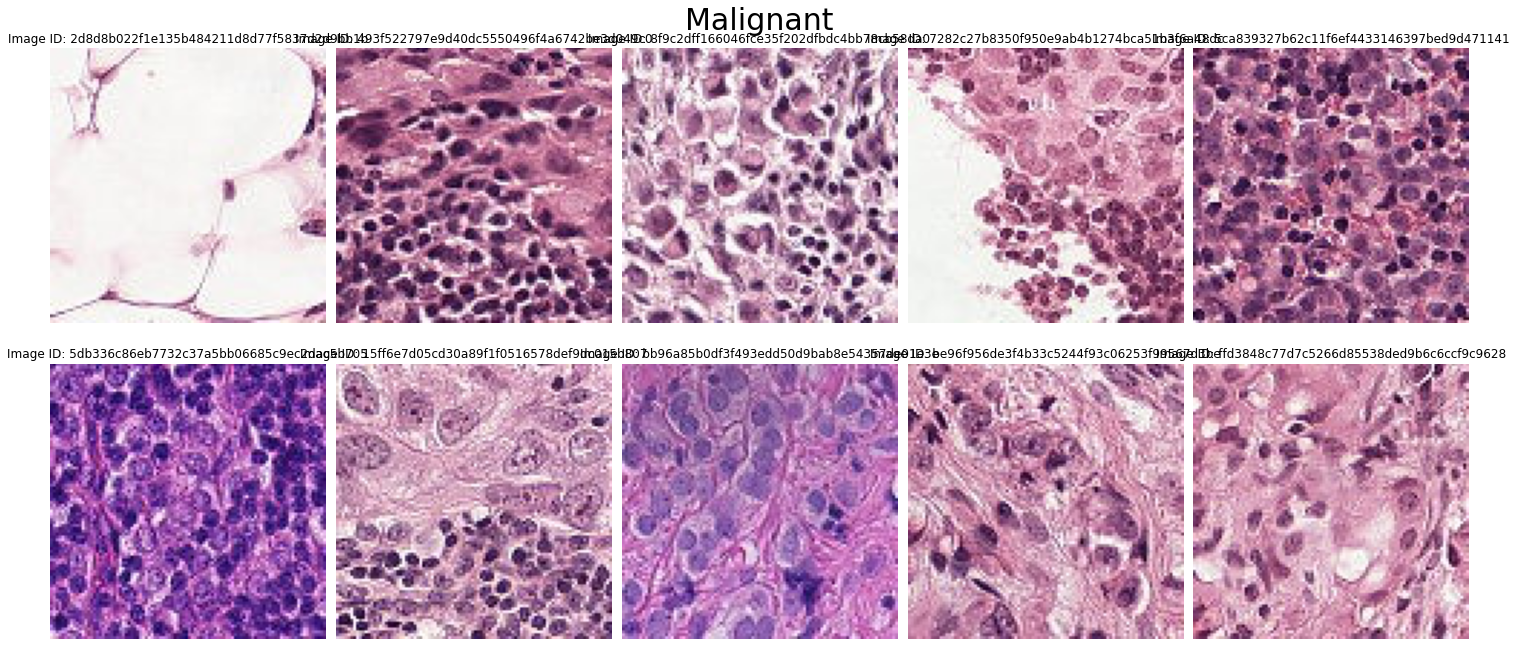

In [10]:
visualize_images(df_labels, 'Malignant', train, label=1, num_images=10)

In [2]:
visualize_images(df_labels, 'Normal', train, label=0, num_images=10)

NameError: name 'visualize_images' is not defined

## 3. Model Architecture

For the model architecture, I will first start with a simple convolution neural network (CNN) to establish a baseline. Following which, I went to tune the hyperparamters such as learning rate, batch size, number of epochs and optimiser.

In [29]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import concurrent.futures


In [30]:
# Function to load images and preprocess them

# Function to load and preprocess a single image
def load_images(image_ids, image_dir, image_size=(96, 96)):
    images = []
    for img_id in image_ids:
        img_path = os.path.join(image_dir, img_id + '.tif')
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img)
        img /= 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Split the data into training and validation sets
train_ids, val_ids, train_labels, val_labels = train_test_split(
    df_labels['id'], df_labels['label'], test_size=0.2, stratify=df_labels['label'], random_state=42
)

# Load training and validation images
X_train = load_images(train_ids, train)
X_val = load_images(val_ids, train)
y_train = to_categorical(train_labels.values)
y_val = to_categorical(val_labels.values)

# Check the shapes of the loaded data
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')


X_train shape: (8000, 96, 96, 3), y_train shape: (8000, 2)
X_val shape: (2000, 96, 96, 3), y_val shape: (2000, 2)


In [31]:
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (96, 96, 3)
model = create_cnn_model(input_shape)
model.summary()

/Users/yeoshaojie/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,034 (6.61 MB)

 Trainable params: 1,732,034 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Calculate steps per epoch and validation steps
steps_per_epoch = np.ceil(len(X_train) / 32).astype(int)
validation_steps = np.ceil(len(X_val) / 32).astype(int)

# Custom generator to repeat the dataset
def repeat_generator(generator):
    while True:
        for batch in generator:
            yield batch
            
train_generator_repeated = repeat_generator(train_generator)
val_generator_repeated = repeat_generator(val_generator)

# Check the number of steps
print(f'Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}')

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Debugging: Print first few batches to confirm generators work as expected
for X_batch, y_batch in train_generator:
    print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')
    break

for X_batch, y_batch in val_generator:
    print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')
    break

# Train the model
history = model.fit(
    train_generator_repeated,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator_repeated,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Explicitly close the generators to avoid running out of sequence
train_generator.on_epoch_end()
val_generator.on_epoch_end()


Steps per epoch: 250, Validation steps: 63
X_batch shape: (32, 96, 96, 3), y_batch shape: (32, 2)
X_batch shape: (32, 96, 96, 3), y_batch shape: (32, 2)
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 341ms/step - accuracy: 0.6290 - loss: 0.6659 - val_accuracy: 0.6910 - val_loss: 0.5862 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.7647 - loss: 0.5094 - val_accuracy: 0.6375 - val_loss: 0.7822 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 322ms/step - accuracy: 0.7608 - loss: 0.5167 - val_accuracy: 0.6860 - val_loss: 0.7752 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 326ms/step - accuracy: 0.7794 - loss: 0.4861 - val_accuracy: 0.7805 - val_loss: 0.4632 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.7752 - loss: 0.4829 - val_accuracy: 0.7960 - val_loss: 0.4562 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 324ms/step - accuracy: 0.794

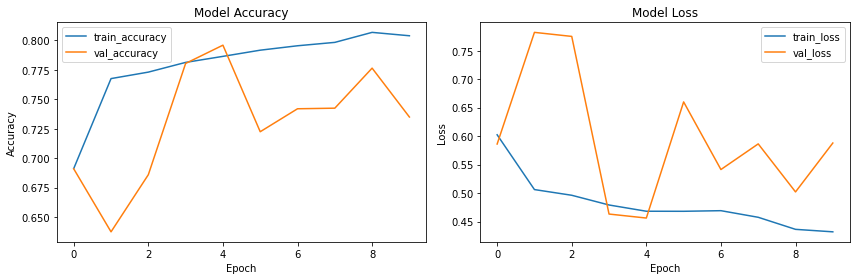

 1/63 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.7812 - loss: 0.4747

/Users/yeoshaojie/opt/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.7950 - loss: 0.4696
Validation Loss: 0.46029719710350037
Validation Accuracy: 0.7954999804496765


In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

In [34]:
#Tune hyperparameter
def build_model(hp):
    model = Sequential()

    # Hyperparameter for the number of filters in each convolutional layer
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
                     (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                     (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
                     (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(2, activation='softmax'))

    # Hyperparameter for the optimizer
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [35]:
#create tuner
import keras_tuner as kt

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [36]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_generator_repeated,
             steps_per_epoch=steps_per_epoch,
             validation_data=val_generator_repeated,
             validation_steps=validation_steps,
             epochs=10,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is {best_hps.get('conv_1_filter')}, 
the optimal number of filters in the second convolutional layer is {best_hps.get('conv_2_filter')},
the optimal number of filters in the third convolutional layer is {best_hps.get('conv_3_filter')},
the optimal number of units in the dense layer is {best_hps.get('dense_units')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal optimizer is {best_hps.get('optimizer')}.
""")


Trial 30 Complete [00h 15m 51s]
val_accuracy: 0.762499988079071

Best val_accuracy So Far: 0.8209999799728394
Total elapsed time: 02h 50m 21s

The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is 48, 
the optimal number of filters in the second convolutional layer is 64,
the optimal number of filters in the third convolutional layer is 48,
the optimal number of units in the dense layer is 128,
the optimal dropout rate is 0.30000000000000004,
and the optimal optimizer is rmsprop.



In [37]:
#best model
# Retrain the model with the best hyperparameters
best_model = build_model(best_hps)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = best_model.fit(
    train_generator_repeated,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator_repeated,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 389ms/step - accuracy: 0.6213 - loss: 0.6781 - val_accuracy: 0.7040 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 358ms/step - accuracy: 0.7467 - loss: 0.5342 - val_accuracy: 0.7320 - val_loss: 0.5738 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 364ms/step - accuracy: 0.7780 - loss: 0.4963 - val_accuracy: 0.6905 - val_loss: 0.5848 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 372ms/step - accuracy: 0.7694 - loss: 0.4958 - val_accuracy: 0.7495 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 375ms/step - accuracy: 0.7687 - loss: 0.5010 - val_accuracy: 0.6865 - val_loss: 0.7645 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 382ms/step - accuracy: 0.7795 - loss: 0.4803 - val_accuracy: 0.7250 - val_loss: 0.6014 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 360ms/step - accuracy: 0.

## 4. Results and analysis

For the results and analysis, I trained the different models and evaluate their performance on the validation set. Moreover, evaluation was done on the models using metrics like ROC-AUC, accuracy, precision, recall, and F1-score. Lastly, visualisations such as plots of training/validation loss and accuracy, ROC curves, and confusion matrices were depicted.

In [38]:
#using sample data
# Function to load test images
def load_test_images(image_ids, image_dir, image_size=(96, 96)):
    images = []
    for img_id in image_ids:
        img_path = os.path.join(image_dir, img_id + '.tif')
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img)
        img /= 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load the test images based on sample submission file
test_image_ids = df_samples['id'].values
X_test = load_test_images(test_image_ids, test)


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Make predictions
y_pred_test = best_model.predict(X_test)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Save the predictions in the required format
df_samples['label'] = y_pred_test_labels
df_samples.to_csv('/Users/yeoshaojie/Desktop/Intro to Deep Learning/Week 3/histopathologic-cancer-detection/output_submission.csv', index=False)

# Get validation data in a suitable format
def get_validation_data(generator):
    X_val, y_val = [], []
    for _ in range(validation_steps):
        X_batch, y_batch = next(generator)
        X_val.append(X_batch)
        y_val.append(y_batch)
    return np.concatenate(X_val), np.concatenate(y_val)

# Get validation data in a suitable format
X_val_data, y_val_data = get_validation_data(val_generator)

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_data)

# Convert probabilities to binary labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val_data, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes)
recall = recall_score(y_val_true, y_val_pred_classes)
f1 = f1_score(y_val_true, y_val_pred_classes)
roc_auc = roc_auc_score(y_val_true, y_val_pred[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 209s 115ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step
Accuracy: 0.808
Precision: 0.8033033033033034
Recall: 0.6789340101522843
F1 Score: 0.735900962861073
ROC AUC: 0.8740628821765426


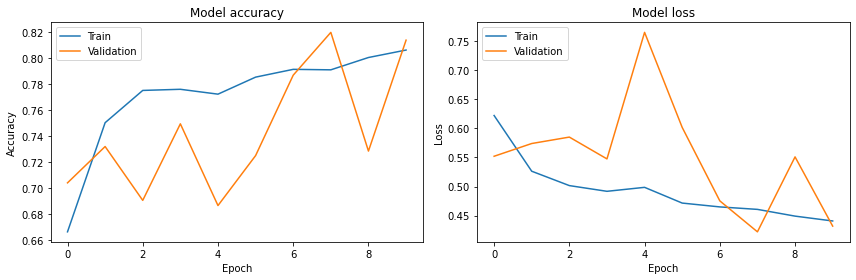

In [41]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

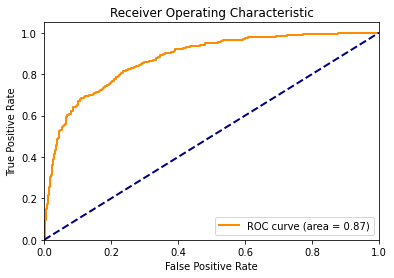

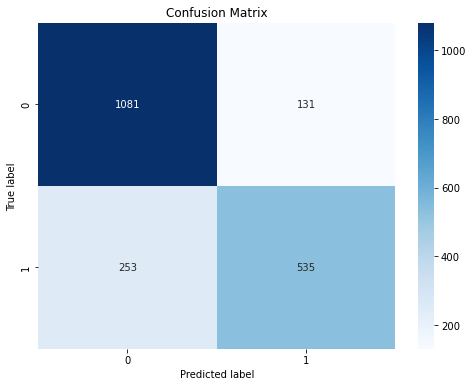

In [42]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 5. Conclusion

### Description and evaluation

Overall, the model proved to be relatively successful. In terms of model performance metrics, here are the results and evaluation.

Accuracy: 0.808
- An accuracy of 80.8% is quite good for a medical imaging task, indicating that the model is making correct predictions most of the time.

Precision: 0.8033
- The model is reliable in its positive predictions. When it predicts a sample as positive, it is correct 80.33% of the time.

Recall: 0.6789
- The recall value suggests that the model is missing some positive samples (false negatives). This is critical in medical diagnostics, where missing a cancerous sample could have significant consequences.

F1 Score: 0.7359
- The F1 score of 0.7367 reflects a balanced trade-off between precision and recall. Given the context of cancer detection, improving recall should be a priority even if it slightly reduces precision.

ROC AUC: 0.8741
- An AUC of 0.8741 is excellent, showing that the model is good at distinguishing between cancerous and non-cancerous samples.


In terms of visualisations, the accuracy plot for both training and validation accuracy improved steadily over epochs, converging around the 9th epoch, indicating good model learning. For the loss plot, both training and validation loss decreased steadily, showing that the model is learning and generalizing well without overfitting.

The ROC curve shows the trade-off between sensitivity (recall) and specificity. The area under the curve (AUC) is 0.87, indicating a high level of discrimination between positive and negative classes.

As for the confusion matrix, the model has more false negatives compared to false positives, suggesting that while it is good at identifying non-cancerous samples, there is room for improvement in identifying cancerous samples. There is still room for improvement for the model as it is undesirable to have more false negative when trying to detect cancer. 

### Recommendations for improvement


1. Improving Recall:

    - Data Augmentation: Apply more aggressive data augmentation techniques to increase the variety of training samples.
    - Class Imbalance: Address class imbalance by using techniques such as oversampling the minority class (cancerous samples) or using class weights during training.
    - Model Architecture: Experiment with more complex model architectures or use pre-trained models with transfer learning to improve feature extraction.


2. Hyperparameter Tuning:

    - Continue to refine hyperparameters with a focus on increasing recall, possibly using a different search strategy like Bayesian optimization.


3. Ensemble Methods:

    - Combine multiple models to create an ensemble that may improve overall performance and robustness.


4. Post-Processing:

    - Implement post-processing techniques to further refine predictions, such as threshold adjustment based on precision-recall trade-offs.

